## Idea:
How accurately can we measure the position using a complete forward model?
We can use the whole image generation machinery with the tip/tilt, binary separation, contrast and position angle as parameters. Some possible problems are the speed, how well it can cope with things that aren't simulated (like higher order terms, smearing due to jitter etc.). So I'll have to test that.

Using 100 wavelengths, takes ~12s to make one image.\
Using 20 wavelengths, takes ~2s to make one image. Would be nice to speed this up somehow... MFT on restricted FoV?

Clearly can't use lookup table because we'd need 1e6 entries in each position direction.

I could do this with a class that contains all of the telescope info, but since it's just for testing it's easier to put everything in memory with notebook cells.

## Result:
Works very well, but very slow.

## Effects of weighted least squares:
Tried fitting to noiseless images with jitter only. I fit only to the first 30/100 images in the sequence used below, which is why the numbers are different.\
With WLS: 45ppm.\
With OLS: 7ppm.


## Effects of WFE:
With no WFE, noise stddev is 6.12ppm. (5.3ppm when using stricter xtol, 1.43ppm when using 100 wavs)\
With 1nm RMS WFE, noise stddev is 38ppm.\
With 5nm RMS WFE, noise stddev is 270 ppm.\
With 10nm RMS WFE, noise stddev is 534 ppm.\
With 20nm RMS WFE, noise stddev is 1058 ppm. \
With 50nm RMS WFE, noise stddev is 2879 ppm. \
With 100nm RMS WFE, noise stddev is 8609 ppm. \

## Effects of individual WFE terms:
Tried using same WFE as the 100nm RMS WFE sim above, but using one term only.\
With defocus only (38nm RMS WFE), noise stddev is 534ppm. First few frames contribute almost all of the scatter, 224ppm otherwise. \
With astigmatism only (58nm RMS WFE), noise stddev is 5413ppm. First few frames dominate again, 1634ppm otherwise \
With coma only (42nm RMS WFE), noise stddev is 5100ppm.
So astigmatism and coma affect the image similarly.

## Effects of photon noise on Forward Model:
1e2 photons peak: 15536 ppm.\
1e3 photons peak: 5170 ppm.\
1e4 photons peak: 1565 ppm.\
1e5 photons peak: 599 ppm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import multiprocessing as mp
import os
import scipy

# Add the simulation directory to path
import sys
sys.path.append('/Users/cheetham/code/toliman/Toliman/COIN/new_sims/')
sys.path.append('/Users/cheetham/Dropbox/code/toliman/Toliman/lib/')
import functions
import photometry
from modelling_functions import larkin_transform_fit

In [2]:
# Prepare all the things we need to make the images
toliman_dir = '/Users/cheetham/code/toliman/Toliman/COIN/'

# Step 1: Define all the parameters that we need
n_cores = 2
m2_obsc = 0 # m
aperture = 0.1 # m
focal_length = 3.65 # 15cm camera lens
pix_size = 6.5e-6 # 1.12 microns
npix = 256 # Only simulate central region to decrease computational complexity
transform_size = 2**10 # 1024 size of the transformed array

# Sims for Eduardo
# aperture = 0.08
# focal_length=2.6
# pix_size=5.5e-6

# Get the spectrum
specA = np.load(toliman_dir+"new_sims/AcenA_cps_1.npy")
specB = np.load(toliman_dir+"new_sims/AcenB_cps_1.npy")
wavels = np.load(toliman_dir+"new_sims/Wavelengths.npy")

# Sims for Eduardo
# specA = np.load(toliman_dir+"new_sims/AcenA_current_sim.npy")
# specB = np.load(toliman_dir+"new_sims/AcenB_current_sim.npy")
# wavels = np.load(toliman_dir+"new_sims/current_sim_wavelengths.npy")

wavels = np.array(wavels, dtype=np.int)
natural_ratio = np.sum(specA)/np.sum(specB)

# Set flux ratio (total flux acenA / total flux acenB)
# To return to the astrophysical flux ratio set flux_ratio = natural_ratio 
diverse_spec = True # If True the two stars spectrums will not be identical
flux_ratio = natural_ratio
if diverse_spec:
    specB = specB*natural_ratio/flux_ratio
else:
    specB = specA/flux_ratio

# Only simulate some wavelengths to save time
skip = 5
wavels = wavels[::skip]
specA = specA[::skip]
specB = specB[::skip]
print('Using',len(wavels),'wavelengths')
    
folder_name = 'forward_model_data'
    
# Make a folder for the temporary data
temp_file_dir = toliman_dir+'/signal_extraction/'+folder_name+'/'
for subdir in [temp_file_dir,temp_file_dir+'pupils/']:
    if not os.path.exists(subdir):
        print('Folder not found. Making it.')
        os.makedirs(subdir)

Using 21 wavelengths


In [44]:
%%time
# Step 2: Make all the pupils
pupil_in = np.load("/Users/cheetham/code/toliman/Toliman/COIN/pupil_scaled.npy")
sizes = []
for wl in wavels:
    # Caclaute how big the pupil array needs to be to get our desired Fourier Transformed array size
    plate_scale = pix_size/focal_length    # Radians per pixel
    spatial_freq = (wl*1e-9)/aperture
    scale_factor = spatial_freq/plate_scale
    size_out = int(transform_size/scale_factor)
    sizes.append([size_out, wl,pupil_in,folder_name])
with mp.Pool(processes=n_cores) as pool:
    null = pool.map(functions.make_pupil, sizes)   

CPU times: user 54.6 ms, sys: 69.3 ms, total: 124 ms
Wall time: 1.28 s


In [3]:
# Function to make 1 image
def image_model(offset_x,offset_y,binary_sep,binary_pa,total_flux,wfe_terms = None):
    """ Make one image of the alpha cen binary with a given jitter and binary parameters.
    This relies on lots of things in memory that aren't passed as parameters so be careful.
    
    """
    # Convert to numbers we need
    # r and phi are the total offset of each psf from the centre 
    prim_r = np.hypot(offset_x,offset_y)
    prim_phi = np.arctan2(offset_x,offset_y)
    sec_x = offset_x + binary_sep*np.sin(binary_pa)
    sec_y = offset_y + binary_sep*np.cos(binary_pa)
    sec_r = np.hypot(sec_x,sec_y)
    sec_phi = np.arctan2(sec_x,sec_y)
    
    full_im = np.zeros((npix,npix))
    for wl_ix,wl in enumerate(wavels):
        pupil = np.load("{}/pupils/{}.npy".format(folder_name, wl))
        
        # If wavefront_error
        if wfe_terms is not None:
            wavefront_error = functions.add_zernikes(wfe_terms,pupil.shape)
        else:
            wavefront_error = None
        
        PSF1 = functions.model_PSF(pupil, aperture, m2_obsc, npix, wl*1e-9, focal_length, 
                                   pix_size, transform_size, prim_r, prim_phi, wavefront_error=wavefront_error)
        PSF2 = functions.model_PSF(pupil, aperture, m2_obsc, npix, wl*1e-9, focal_length, 
                                   pix_size, transform_size, sec_r, sec_phi, wavefront_error=wavefront_error)
        full_im += PSF1*specA[wl_ix]
        full_im += PSF2*specB[wl_ix]
    full_im *= total_flux/np.sum(full_im)
    return full_im

In [4]:
%%time
# How long does one function evaluation take?
offset_x = 0 # jitter
offset_y = 0 # jitter
binary_sep = 44.91985222# # this will have the signal. (in pixels)
# binary_sep = 37.8154671265438 #
binary_pa = 0*np.pi/2 # we wont care about this

im = image_model(offset_x,offset_y,binary_sep,binary_pa,1.)#,wfe_terms={(0,2):1e-9})

CPU times: user 2.17 s, sys: 590 ms, total: 2.76 s
Wall time: 2.83 s


Text(0.5, 1.0, 'Residuals')

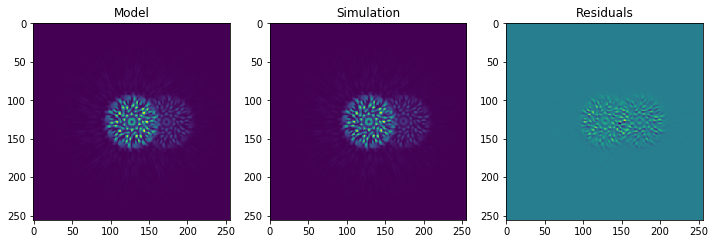

In [47]:
# An image to test on
# sim_name = '../sims/eduardo_sims/'
sim_name = '../sims/zernike_both_stars/'
input_im = np.load(sim_name+"images/{}.npy".format(0)).astype(float)
input_im -= np.mean(input_im[0:50,0:50]) # background subtract
input_im/= np.sum(input_im)

plt.figure(figsize=(12,5))
plt.subplot(131)
plt.imshow(im);plt.title('Model')

plt.subplot(132)
plt.imshow(input_im);plt.title('Simulation')

plt.subplot(133)
plt.imshow(input_im-im);plt.title('Residuals')

In [48]:
def lsq_func(params,*args,**kwargs):
    """ Function used in forward modelling of Toliman images for the binary separation measurement.
    It returns the residuals of a model - input image. It relies on lots of things in memory, and
    has a few magic numbers, like the rough binary separation that we will be fitting to.
    Inputs:
        params = [offset_x, offset_y, binary_sep_offset]:
            offset_x,offset_y are the initial estimates of the jitter positions
            binary_sep_offset is the offset from a hard-coded separation of 44.91985222 pixels
        kwargs['input_im']:
            The image we're trying to model
        kwargs['crop_size'] (Optional):
            Used to perform the fit to a cropped region around the centre of the image.
            crop_size will be the x,y size of the region for the fit
        kwargs['weighted_least_squares'] (Optional):
            Set to True to weight each image pixel by sqrt(model_im)
            

    Outputs:
        A 1D array of residuals, i.e. input_im - model_im
        
    """
    input_im = kwargs['input_im']
    
    # Default values of some params
    binary_pa = 0
    total_flux = 1.
    defocus = None
    wfe_terms = None
    
    # Infer the parameters based on how many are included
    if len(params) == 1:
        binary_sep_offset = params[0]
        offset_x = kwargs['offset_x']
        offset_y = kwargs['offset_y']
    elif len(params) == 3:
        offset_x,offset_y,binary_sep_offset = params 
    elif len(params) == 4:
        offset_x,offset_y,binary_sep_offset,binary_pa = params
    elif len(params) == 5:
        offset_x,offset_y,binary_sep_offset,binary_pa,total_flux = params
    elif len(params) == 6:
        offset_x,offset_y,binary_sep_offset,binary_pa,total_flux,defocus = params
        wfe_terms = {(0,2):defocus}
    elif len(params) == 8:
        offset_x,offset_y,binary_sep_offset,binary_pa,total_flux,defocus,astigx,astigy = params
        wfe_terms = {(0,2):defocus,(-2,2):astigx,(2,2):astigy}        
    
    binary_sep = 44.91985222 + binary_sep_offset
#     binary_sep = 37.8154671265438 + binary_sep_offset
    model_im = image_model(offset_x,offset_y,binary_sep,binary_pa,total_flux,wfe_terms=wfe_terms)
    
    resids = (input_im-model_im)
    if 'crop_size' in kwargs:
        crop_size = kwargs['crop_size']
        resids = resids[resids.shape[0]//2-crop_size//2:resids.shape[0]//2+crop_size//2,
                        resids.shape[1]//2-crop_size//2:resids.shape[1]//2+crop_size//2]

    if 'weighted_least_squares' in kwargs:
        if kwargs['weighted_least_squares']:
            # we want cost_function = sum((data-model)**2 / model)
            # but cost_function = sum(resids**2)
            weights = np.sqrt(model_im)
            resids /= weights
    
    return resids.ravel()

def chi2(params,input_im = None):
    resids = lsq_func(params,input_im=input_im)
    chi2 = np.sum(resids**2)
    return chi2

CPU times: user 2.14 s, sys: 564 ms, total: 2.71 s
Wall time: 2.71 s


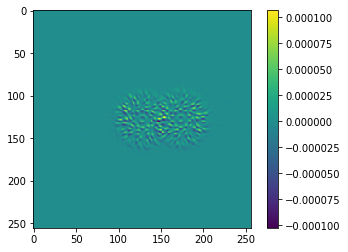

In [49]:
%%time
# Fit to one image (used for testing things)
input_im = np.load(sim_name+'images/0.npy')
input_im = input_im/np.sum(input_im)

x0 = [0.,0.,0.0]
# x0 = [jitters[0,1],jitters[0,0],0.]
# x0_fixedpos = [0.]

# kwargs = {'input_im':input_im,'weighted_least_squares':False,'offset_x':jitters[0,1],'offset_y':jitters[0,0]}
# # fit = scipy.optimize.minimize(chi2, x0, args=(input_im),method='Powell')#,options={'ftol':1e-2})
# fit = scipy.optimize.least_squares(lsq_func,x0,method='lm',ftol=None,xtol=1e-6,kwargs=kwargs) # LM
# fit = scipy.optimize.least_squares(lsq_func,x0_fixedpos,method='lm',ftol=None,xtol=1e-6,kwargs=kwargs) # LM

# Test the resids
resids = lsq_func(x0,input_im=input_im,weighted_least_squares=False)

resids_2d = np.reshape(resids,(256,256))

plt.imshow(resids_2d)
# plt.imshow(input_im-resids_2d)
plt.colorbar()

In [50]:
sim_name= '../sims/zernike_both_stars/'

In [51]:
signal = np.loadtxt(sim_name+'signal.csv',skiprows=1,delimiter=',')

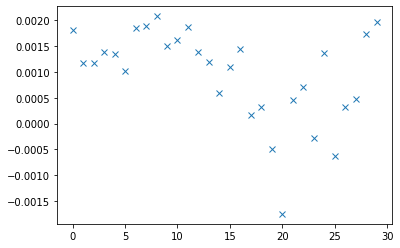

`xtol` termination condition is satisfied.
Function evals: 31
Final sep: 0.0019736407650723514
CPU times: user 58min 6s, sys: 18min 44s, total: 1h 16min 50s
Wall time: 1h 16min 18s


In [53]:
%%time
from IPython.display import clear_output
# Loop over some images
seps = []

params = []
weighted_least_squares = False # just makes it worse
rough_position = True # use the Larkin Transform to get a rough position before the main fit.
rough_sep = 44.91985222
# rough_sep = 37.8154671265438

for ix in np.arange(0,30):
    input_im = np.load(sim_name+"images/{}.npy".format(ix))
    input_im= input_im/np.sum(input_im)
    
    if rough_position:
        model_PSF = np.load(sim_name+'model_psf.npy')
        # Rough position from fitting the Larkin Transform
        transformed_im = photometry.larkin_transform(model_PSF,input_im)
        transformed_im = transformed_im**2 # Square it!
        transformed_im /= np.max(transformed_im)

        # Fit
        x0 = [0,0,1.2,2.5,rough_sep,0.,0.25,3.] # good starting point for airy disk
        prim_fit,sec_fit = larkin_transform_fit(x0,transformed_im,plot=False,fit_airy=True,
                                                rough_sep_pix=int(round(rough_sep)))
        # Turn it to parameters
        delx = prim_fit.x_0-sec_fit.x_0
        dely = prim_fit.y_0-sec_fit.y_0
        sep = np.sqrt(delx**2 + dely**2)
        pa = np.arctan2(dely,-delx)

        x0 = [-prim_fit.y_0.value,prim_fit.x_0.value,sep-int(round(rough_sep)),pa,1.]
    else:
        x0 = [0,0,0.1516]
        
    # Temp code for testing the influence of the number of parameters
    kwargs = {'input_im':input_im,'weighted_least_squares':weighted_least_squares}

    fit = scipy.optimize.least_squares(lsq_func,x0,method='lm',kwargs=kwargs,ftol=None,xtol=1e-6) # LM
    
    sep = fit.x[2]
#     sep = fit.x[0]

    params.append(fit.x)
    
    seps.append(sep)

    clear_output(wait=True)
    plt.plot(seps,'x')
    plt.show()
#     raise Exception()
    print(fit.message)
    print('Function evals:',fit.nfev)
    print('Final sep:',sep)
seps = np.array(seps)
# pas = np.array(pas)
params = np.array(params)

<Figure size 432x288 with 0 Axes>

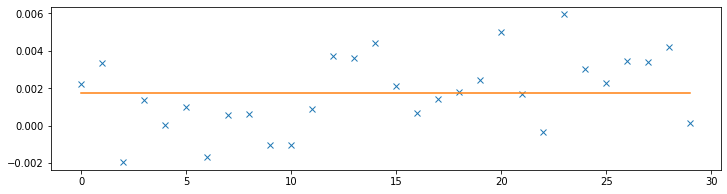

In [30]:
# Plot of seps vs time (with a line showing the signal)
plt.clf()
plt.figure(figsize=(12,3))
# plt.subplot(121)
plt.plot(seps,'x')
plt.plot(signal[:,1]+np.median(seps),'-')

# plt.subplot(122)
# plt.plot(pas,'x')

(-0.012316559386311595, 0.2904041245759549)

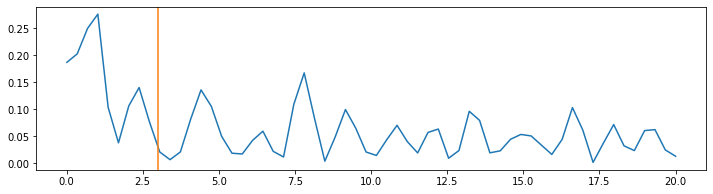

In [31]:
# Plot the frequencies with a Lomb-Scargle
from astropy.timeseries import LombScargle
frequency = np.linspace(0.01, 20., len(seps)*2)
t = np.arange(seps.shape[0])/seps.shape[0]
plt.figure(figsize=(12,3))
power = LombScargle(t, seps).power(frequency)
plt.plot(frequency,power)
yl = plt.ylim()
plt.plot([3.,3.],yl,'-') # This is the signal frequency I've been using
plt.ylim(yl)

In [32]:
print('Accuracy in ppm:',np.std(seps)*1e6)
print('signal subtracted:',np.std(seps-signal[:len(seps),1])*1e6)#,np.std(pas)*1e6)

Accuracy in ppm: 1967.8200781802166
signal subtracted: 1967.8200781802166


## More results:
Fitting to jitter only with the same 30 ims.
Want to see how the number of parameters affects the fit.
Looking at the 6 param fit, PA, flux and defocus are all correlated with the separation.
PA and Flux are basically degenerate for some reason. And PA/Flux and defocus are very correlated too. That didn't quite hold when astigmatism was added too, but they were still correlated.

I don't understand why we get different behaviour when different parameters are added. Fixing the jitter or the flux to the correct values introduces more scatter than letting the fit get it wrong. But fixing the position angle makes the fit better?

1 param: (Separation): 9.57 ppm.\
3 params: (Jitter, Separation): 5.96 ppm.\
4 params: (Jitter, Separation, Position angle): 6.46ppm.\
5 params: (Jitter, Separation, Position angle, Flux):  4.75ppm.\
6 params: (Jitter, Separation, Position angle, Flux, Defocus): 78ppm.\
8 params: (Jitter, Separation, Position angle, Flux, Defocus, Astigmatism): 228ppm.

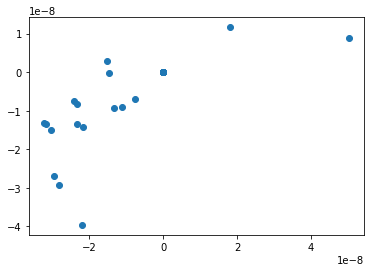

In [89]:
# Is the defocus correlated with the separation? Yes
# params are: jitterx, jittery, sep, PA, flux, defocus
# plt.plot(params[:,2],np.abs(params[:,7])*1e9,'o');plt.ylabel('AstigX (nm)')
# plt.plot(params[:,2],np.abs(params[:,5])*1e9,'o');plt.ylabel('Defocus (nm)')
# plt.plot(params[:,2],params[:,4],'o');plt.ylabel('Flux')
# plt.plot(params[:,2],params[:,3],'o');plt.ylabel('PA')
# plt.plot(params[:,2],params[:,0],'o');plt.plot(params[:,2],params[:,1],'o');plt.ylabel('Position')
# plt.xlabel('Separation (pix)')

# plt.plot(params[:,3],params[:,4],'o') # PA and flux are basically degenerate.
# plt.plot(params[:,4],params[:,5],'o') # Flux and defocus are heavily correlated too (parabola)
# plt.plot(params[:,3],params[:,5],'o') # PA and defocus are heavily correlated too (parabola) (since PA/flux are degenerate)
plt.plot(params[:,6],params[:,7],'o')

